# Speech Command Recognition - Baseline

A simple baseline for the **Last Frequency** speech command classification competition.

**Approach:**
1. Convert raw audio waveforms to mel-spectrograms
2. Train a simple CNN
3. Generate submission

**Expected accuracy: ~40-50%**

Plenty of room for improvement!

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print(f'PyTorch: {torch.__version__}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

torch.manual_seed(42)
np.random.seed(42)

PyTorch: 2.8.0+cu126
Device: cpu


## Load Data

In [2]:
DATA_DIR = '/kaggle/input/the-last-frequency'

# Load training data (raw audio waveforms)
train_waveforms = np.load(f'{DATA_DIR}/train_waveforms.npy')
train_labels = np.load(f'{DATA_DIR}/train_labels.npy')

# Load label map
with open(f'{DATA_DIR}/label_map.json') as f:
    label_map = {int(k): v for k, v in json.load(f).items()}

num_classes = len(label_map)
SAMPLE_RATE = 16000

print(f'Waveforms: {train_waveforms.shape}')
print(f'Labels: {train_labels.shape}')
print(f'Classes: {num_classes}')
print(f'Commands: {list(label_map.values())}')

Waveforms: (8479, 16000)
Labels: (8479,)
Classes: 35
Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


## Convert Waveforms to Spectrograms

Mel-spectrograms convert audio into 2D images that CNNs can process:
- **X-axis** = Time
- **Y-axis** = Frequency (mel scale)
- **Brightness** = Energy

In [3]:
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256
TARGET_FRAMES = 64

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
)
amplitude_to_db = torchaudio.transforms.AmplitudeToDB()


def waveforms_to_spectrograms(waveforms):
    """Convert an array of waveforms to normalized spectrograms."""
    specs = []
    for waveform in waveforms:
        wave_tensor = torch.from_numpy(waveform).float().unsqueeze(0)
        spec = amplitude_to_db(mel_transform(wave_tensor)).squeeze(0).numpy()
        # Pad/truncate to TARGET_FRAMES
        if spec.shape[1] > TARGET_FRAMES:
            spec = spec[:, :TARGET_FRAMES]
        elif spec.shape[1] < TARGET_FRAMES:
            spec = np.pad(spec, ((0, 0), (0, TARGET_FRAMES - spec.shape[1])))
        specs.append(spec)
    return np.array(specs, dtype=np.float32)


print('Converting training waveforms to spectrograms...')
train_specs = waveforms_to_spectrograms(train_waveforms)

# Normalize to [0, 1]
spec_min = train_specs.min()
spec_max = train_specs.max()
train_specs = (train_specs - spec_min) / (spec_max - spec_min)

print(f'Spectrograms: {train_specs.shape}')
print(f'Range: {train_specs.min():.2f} to {train_specs.max():.2f}')

Converting training waveforms to spectrograms...
Spectrograms: (8479, 64, 64)
Range: 0.00 to 1.00


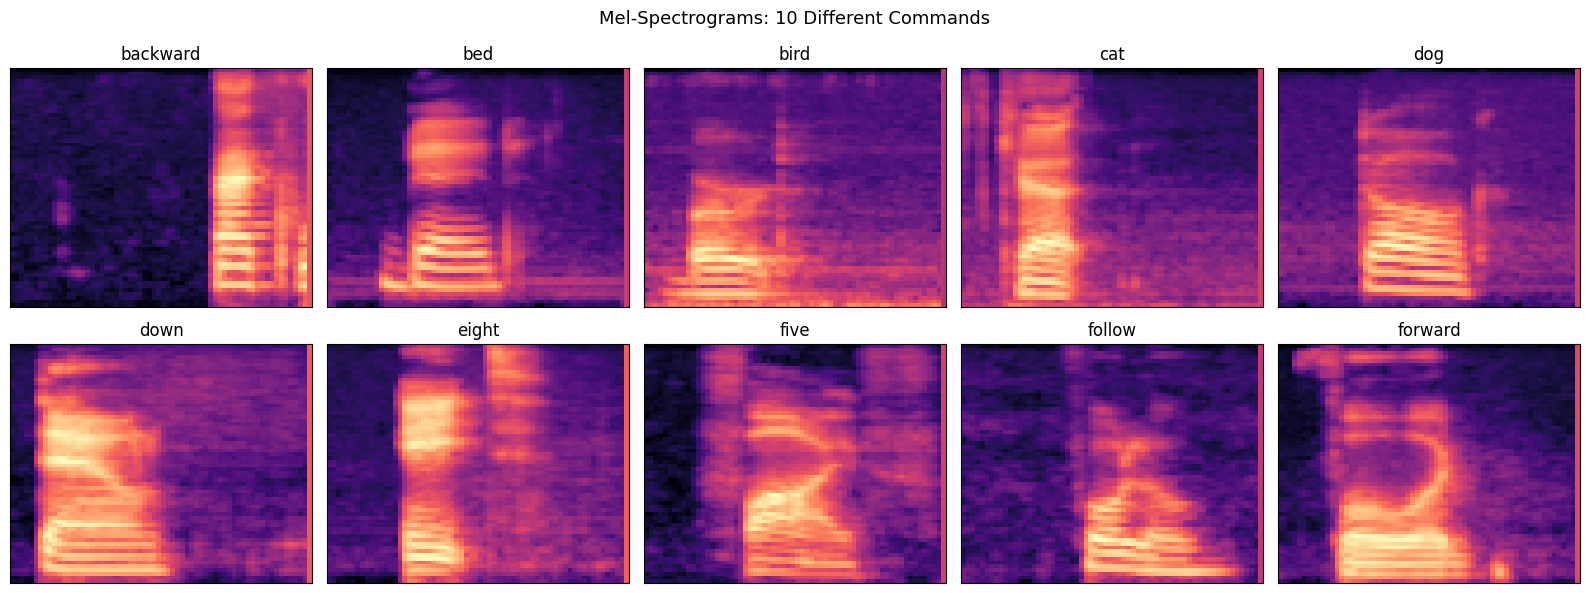

In [4]:
# Visualize a few spectrograms
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i, ax in enumerate(axes.flat):
    idx = np.where(train_labels == i)[0][0]
    ax.imshow(train_specs[idx], cmap='magma', aspect='auto', origin='lower')
    ax.set_title(label_map[i])
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle('Mel-Spectrograms: 10 Different Commands', fontsize=13)
plt.tight_layout()
plt.show()

## Prepare DataLoaders

In [5]:
# Add channel dimension: (N, 64, 64) -> (N, 1, 64, 64)
X = train_specs[:, np.newaxis, :, :]
y = train_labels.astype(np.int64)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=64, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
    batch_size=128, shuffle=False
)

print(f'Train: {X_train.shape[0]} samples, Val: {X_val.shape[0]} samples')

Train: 7207 samples, Val: 1272 samples


## Simple CNN Model

A minimal CNN — just enough to learn basic patterns.

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=35):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 64 -> 32
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 32 -> 16
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(4),   # 16 -> 4
        )
        self.classifier = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


model = SimpleCNN(num_classes).to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 59,427


## Train

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
best_val_acc = 0
history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    # Train
    model.train()
    correct = total = running_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out = model(X_batch)
        loss = criterion(out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(y_batch)
        correct += (out.argmax(1) == y_batch).sum().item()
        total += len(y_batch)
    train_acc = correct / total
    train_loss = running_loss / total

    # Validate
    model.eval()
    correct = total = running_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            running_loss += loss.item() * len(y_batch)
            correct += (out.argmax(1) == y_batch).sum().item()
            total += len(y_batch)
    val_acc = correct / total
    val_loss = running_loss / total

    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    best_mark = ' *' if val_acc > best_val_acc else ''
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f'Epoch {epoch+1:2d}/{num_epochs} | '
          f'Train: {train_acc:.3f} | Val: {val_acc:.3f}{best_mark}')

model.load_state_dict(best_state)
model.to(device)
print(f'\nBest val accuracy: {best_val_acc:.3f}')

Epoch  1/10 | Train: 0.032 | Val: 0.039 *
Epoch  2/10 | Train: 0.095 | Val: 0.153 *
Epoch  3/10 | Train: 0.215 | Val: 0.241 *
Epoch  4/10 | Train: 0.271 | Val: 0.303 *
Epoch  5/10 | Train: 0.313 | Val: 0.313 *
Epoch  6/10 | Train: 0.334 | Val: 0.329 *
Epoch  7/10 | Train: 0.376 | Val: 0.373 *
Epoch  8/10 | Train: 0.414 | Val: 0.345
Epoch  9/10 | Train: 0.451 | Val: 0.425 *
Epoch 10/10 | Train: 0.486 | Val: 0.458 *

Best val accuracy: 0.458


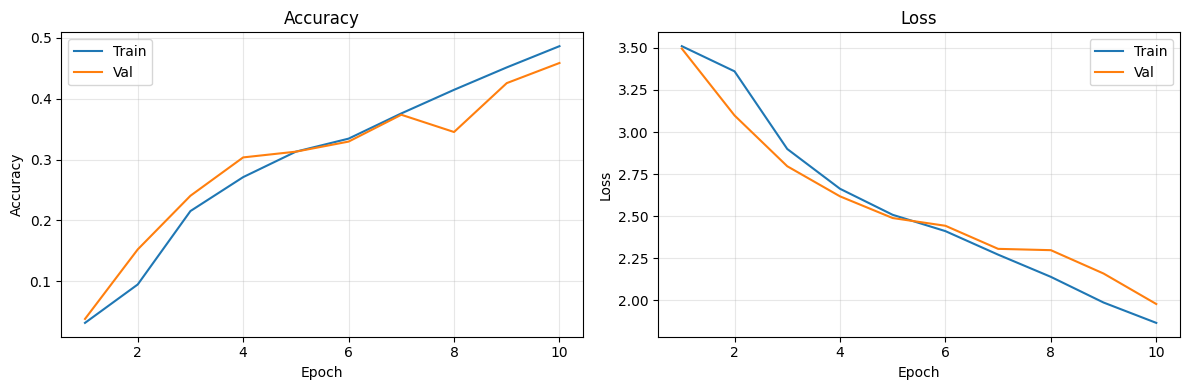

In [8]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs = range(1, num_epochs + 1)

ax1.plot(epochs, history['train_acc'], label='Train')
ax1.plot(epochs, history['val_acc'], label='Val')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy'); ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.plot(epochs, history['train_loss'], label='Train')
ax2.plot(epochs, history['val_loss'], label='Val')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.set_title('Loss'); ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Generate Submission

In [9]:
def predict(model, waveforms):
    """Convert waveforms to spectrograms and predict."""
    specs = waveforms_to_spectrograms(waveforms)
    specs = (specs - spec_min) / (spec_max - spec_min)
    specs = specs[:, np.newaxis, :, :]  # add channel dim

    model.eval()
    preds = []
    loader = DataLoader(TensorDataset(torch.from_numpy(specs)), batch_size=256)
    with torch.no_grad():
        for (batch,) in loader:
            out = model(batch.to(device))
            preds.append(out.argmax(1).cpu().numpy())
    return np.concatenate(preds)


# Load test sets
public_test = np.load(f'{DATA_DIR}/public_test_waveforms.npy')
private_test = np.load(f'{DATA_DIR}/private_test_waveforms.npy')
print(f'Public test:  {public_test.shape}')
print(f'Private test: {private_test.shape}')

print('\nPredicting...')
public_preds = predict(model, public_test)
private_preds = predict(model, private_test)

# Build submission
all_ids = list(range(len(public_preds) + len(private_preds)))
all_commands = [label_map[p] for p in np.concatenate([public_preds, private_preds])]

submission = pd.DataFrame({'Id': all_ids, 'Command': all_commands})
submission.to_csv('submission.csv', index=False)

print(f'\nSaved submission.csv ({len(submission)} rows)')
print(submission.head())

Public test:  (1060, 16000)
Private test: (1060, 16000)

Predicting...

Saved submission.csv (2120 rows)
   Id Command
0   0     yes
1   1    tree
2   2    nine
3   3   right
4   4    bird


## Ideas for Improvement

This baseline is intentionally simple. Here are some directions to explore:

1. **Better architecture** — Add BatchNorm, residual connections, more layers
2. **Data augmentation** — SpecAugment (time/frequency masking), time shifts, noise injection
3. **Training tricks** — Learning rate scheduling, Mixup, longer training
4. **Loss function** — Focal Loss to focus on hard examples ("three" vs "tree")
5. **Different data representation** — Try working directly with raw audio using 1D CNNs

The choice of data representation can significantly impact your results...